In [1]:
import osmnx as ox, networkx as nx, numpy as np
ox.config(log_console=True, use_cache=True)

In [2]:
B = ox.buildings.buildings_from_address('Central Park, New York, New York',distance=900, retain_invalid=False)

In [3]:
# the way to extract the polygon of original data, it turns out that the polygon of buildings is 
# irrelated to the intersection, which is not useful
list(B['geometry'].exterior)[1].coords.xy

(array('d', [-73.9727338, -73.9726613, -73.972537, -73.9725972, -73.9726447, -73.9726565, -73.9727338]),
 array('d', [40.7854326, 40.7855294, 40.7854775, 40.7853952, 40.785415, 40.7853989, 40.7854326]))

In [4]:
centroidseries = B['geometry'].centroid

In [5]:
# Collect the data of building height
import pandas as pd
df = pd.concat([centroidseries.x, centroidseries.y,B['height']], axis=1)
df.columns = ['x','y','height']
df = df.dropna()
df

,x,y,height
204619052,-73.972636,40.785458,28.5
244696021,-73.974217,40.786659,17.2
266898918,-73.963626,40.775811,17.3
266898919,-73.963029,40.776403,26.0
266898923,-73.962750,40.775912,22.4
266898924,-73.962191,40.775785,21.8
266898925,-73.962703,40.775972,22.4
266898926,-73.962663,40.776027,22.6
266898927,-73.962584,40.776085,20.5
266898930,-73.963052,40.776046,21.0


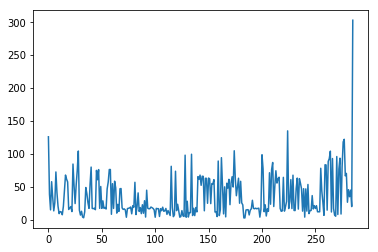

In [6]:
# histogram of the building height
import numpy as np
import matplotlib.pyplot as plt
hh = [float(a) for a in list(df['height'])]
plt.plot(hh)
plt.show()

In [6]:
# filter the map and visulize
G = ox.graph_from_address('Central Park, New York, New York', network_type='drive',distance=900)

In [7]:
Roads = list(G.edges())

In [8]:
# remove the unnecessary road and node
# keep {'primary', 'secondary', 'tertiary', 'residential', 'trunk'} only
for r in Roads:
    proper = G.adj[r[0]][r[1]][0]['highway']
    if 'motor' in proper or 'motor_link' in proper:
        G.remove_edge(r[0],r[1])

In [9]:
Roads = list(G.edges())
node_list = []
for r in Roads:
    node_list.append(r[0])
    node_list.append(r[1])
node_list = set(node_list)

In [10]:
# we need an undirected graph to find neighbors of each node
G_undir = G.to_undirected()

In [11]:
# remove dead end and single node
do = 1
while do > 0:
    Nodes = list(G.nodes())
    G_undir = G.to_undirected()
    for n in Nodes:
        if n not in node_list or len([a for a in G_undir.neighbors(n)]) == 1:
            G.remove_node(n)
    do = len(Nodes) - len(G)

In [12]:
# remove the point that has only two neighbors and is not the boundary point
do = 1
while do > 0:
    Nodes = list(G.nodes())
    G_undir = G.to_undirected()
    for n in Nodes:
        nei = [a for a in G_undir.neighbors(n)]
        if len(nei) == 2:
            slope1 = (G_undir.node[nei[0]]['y']-G_undir.node[n]['y'])/(G_undir.node[nei[0]]['x']-G_undir.node[n]['x'])
            slope2 = (G_undir.node[nei[1]]['y']-G_undir.node[n]['y'])/(G_undir.node[nei[1]]['x']-G_undir.node[n]['x'])
            diff = slope1 - slope2
            if -0.1 < diff < 0.1:
                # remove that node but keep the edges
                G.remove_node(n)
                G.add_edge(nei[0],nei[1])
                break
    do = len(Nodes) - len(G)

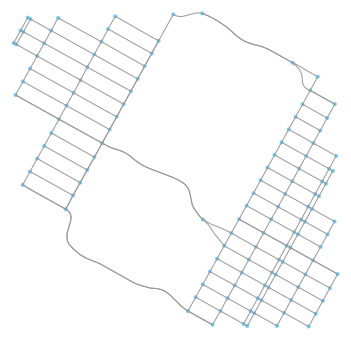

(<Figure size 589.372x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2795759d860>)

In [13]:
ox.plot_graph(G)

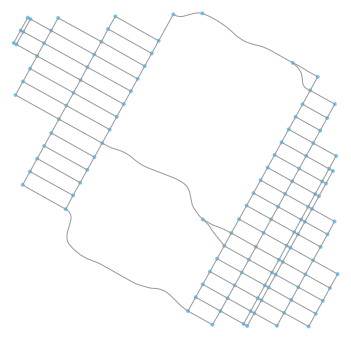

(<Figure size 589.372x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2795758ae10>)

In [14]:
ox.plot_graph(G_undir)

In [89]:
# add building as new nodes
for i in range(len(df)):
    G.add_node(str(i))
    G.node[str(i)]['x'] = df.iloc[i]['x']
    G.node[str(i)]['y'] = df.iloc[i]['y']
    G.node[str(i)]['height'] = df.iloc[i]['height']

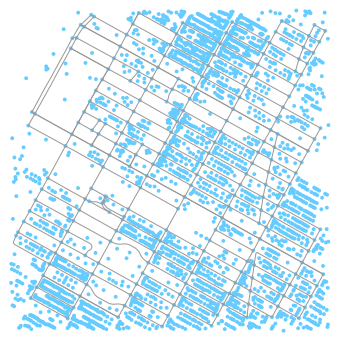

(<matplotlib.figure.Figure at 0x29226b3be10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29226b336d8>)

In [404]:
ox.plot_graph(G)

In [15]:
def slope_cal(a,b,n):
    slope1 = (G_undir.node[a]['y']-G_undir.node[n]['y'])/(G_undir.node[a]['x']-G_undir.node[n]['x'])
    slope2 = (G_undir.node[b]['y']-G_undir.node[n]['y'])/(G_undir.node[b]['x']-G_undir.node[n]['x'])
    diff = slope1 - slope2
    return diff

In [16]:
# Create polygon of the block
block = []
for n in Nodes:
    nei = [a for a in G_undir.neighbors(n)]
    G_test = G_undir.copy()
    G_test.remove_node(n)
    if len(nei) == 2:
        path = nx.bidirectional_shortest_path(G_test, nei[0],nei[1])
        box = [n] + path
        block.append(box)
    elif len(nei) == 3:
        diff1 = slope_cal(nei[0],nei[1],n)
        diff2 = slope_cal(nei[0],nei[2],n)
        diff3 = slope_cal(nei[1],nei[2],n)
        if abs(diff1) > 0.1:
            path1 = nx.bidirectional_shortest_path(G_test, nei[0],nei[1])
            box1 = [n] + path1
            block += [box1]
        if abs(diff2) > 0.1:
            path2 = nx.bidirectional_shortest_path(G_test, nei[0],nei[2])
            box2 = [n] + path2
            block += [box2]
        if abs(diff3) > 0.1:
            path3 = nx.bidirectional_shortest_path(G_test, nei[1],nei[2])
            box3 = [n] + path3
            block += [box3]
    elif len(nei) == 4:
        diff1 = slope_cal(nei[0],nei[1],n)
        diff2 = slope_cal(nei[0],nei[2],n)
        diff3 = slope_cal(nei[0],nei[3],n)
        diff4 = slope_cal(nei[1],nei[2],n)
        diff5 = slope_cal(nei[1],nei[3],n)
        diff6 = slope_cal(nei[2],nei[3],n)
        if abs(diff1) > 0.1:
            path1 = nx.bidirectional_shortest_path(G_test, nei[0],nei[1])
            box1 = [n] + path1
            block += [box1]
        if abs(diff2) > 0.1:
            path2 = nx.bidirectional_shortest_path(G_test, nei[0],nei[2])
            box2 = [n] + path2
            block += [box2]
        if abs(diff3) > 0.1:
            path3 = nx.bidirectional_shortest_path(G_test, nei[0],nei[3])
            box3 = [n] + path3
            block += [box3]
        if abs(diff4) > 0.1:
            path4 = nx.bidirectional_shortest_path(G_test, nei[1],nei[2])
            box4 = [n] + path4
            block += [box4]
        if abs(diff5) > 0.1:
            path5 = nx.bidirectional_shortest_path(G_test, nei[1],nei[3])
            box5 = [n] + path5
            block += [box5]
        if abs(diff6) > 0.1:
            path6 = nx.bidirectional_shortest_path(G_test, nei[2],nei[3])
            box6 = [n] + path6
            block += [box6]     

In [17]:
block

[[42444809, 42436537, 42436539, 42444810],
 [42444809, 42444810, 42446066, 42456575],
 [42433564, 42427915, 42443280, 42433565],
 [42433564, 42435308, 42437300, 42433565],
 [42433565, 42443280, 42427915, 42433564],
 [42433565, 42437300, 42435308, 42433564],
 [1061531682, 1061531768, 42422006, 42428689],
 [1061531682, 1061531768, 42422000, 42437052],
 [1061531682, 42428689, 42428695, 1061531731],
 [1061531682, 1061531731, 42442492, 42437052],
 [42436539, 42436537, 42444809, 42444810],
 [42436539, 42436537, 42445731, 42445733],
 [42436539, 42444810, 596776156, 596776150],
 [42436539, 42445733, 596776103, 596776150],
 [596776115, 42454192, 42429330, 596776164],
 [596776115, 42454192, 42445736, 596776103],
 [596776115, 42446041, 42429324, 596776164],
 [596776115, 42446041, 42445733, 596776103],
 [42444810, 42444809, 42456575, 42446066],
 [42444810, 42444809, 42436537, 42436539],
 [42444810, 42446066, 596776163, 596776156],
 [42444810, 42436539, 596776150, 596776156],
 [4016646206, 42435316

In [18]:
# remove duplicate blocks
from collections import Counter
a_list = []
new_block = []
for b in block:
    if Counter(b) not in a_list:
        a_list.append(Counter(b))
        new_block.append(b)

In [19]:
# Remove the large blocks that comprised of small blocks
block_4 = [b for b in new_block if len(b) == 4]
block_3 = [b for b in new_block if len(b) == 3]
block_small = block_3 + block_4
block_large = []
for b in new_block:
    add = 1
    if len(b) > 4:
        key = list(Counter(b).keys())
        for b_small in block_small:
            key_small = list(Counter(b_small).keys())
            if all(elem in key for elem in key_small):  # the big block contains that small block
                add = 0
                break
        if add == 1:
            block_large.append(b)

In [20]:
# Now is the final blocks that has adjoint with each other
new_block = block_small + block_large

In [21]:
new_block

[[42449187, 42435497, 42433927],
 [42443264, 42443268, 42443263],
 [42444809, 42436537, 42436539, 42444810],
 [42444809, 42444810, 42446066, 42456575],
 [42433564, 42427915, 42443280, 42433565],
 [42433564, 42435308, 42437300, 42433565],
 [1061531682, 1061531768, 42422006, 42428689],
 [1061531682, 1061531768, 42422000, 42437052],
 [1061531682, 42428689, 42428695, 1061531731],
 [1061531682, 1061531731, 42442492, 42437052],
 [42436539, 42436537, 42445731, 42445733],
 [42436539, 42444810, 596776156, 596776150],
 [42436539, 42445733, 596776103, 596776150],
 [596776115, 42454192, 42429330, 596776164],
 [596776115, 42454192, 42445736, 596776103],
 [596776115, 42446041, 42429324, 596776164],
 [596776115, 42446041, 42445733, 596776103],
 [42444810, 42446066, 596776163, 596776156],
 [4016646206, 42435316, 42431447, 42437050],
 [4016646206, 42435316, 42435317, 42443363],
 [4016646206, 42437050, 42437052, 42442492],
 [4016646206, 42443363, 42442502, 42442492],
 [42444812, 42456578, 596776163, 596

In [22]:
def block_coord(b):
    coord = []
    for i in range(len(b)):
        x = G_undir.node[b[i]]['x']
        y = G_undir.node[b[i]]['y']
        coord += [[x,y]]
    return coord

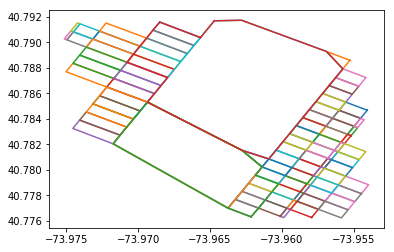

In [23]:
# plot block
import matplotlib.pyplot as plt
for b in new_block:
    coord = block_coord(b)
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #create lists of x and y values
    plt.plot(xs,ys)
plt.show()

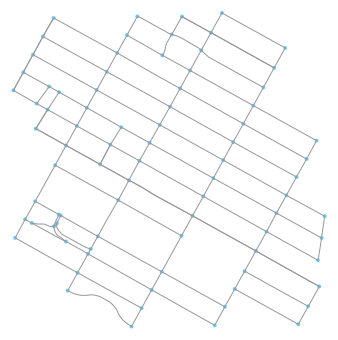

(<Figure size 565.951x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28fe0067eb8>)

In [23]:
# Compare with the original 
# We find out that the some curved street that without node could not be plot accurate.
ox.plot_graph(G)

In [25]:
# check the accuracy of block by the nodes and edges
H = nx.MultiGraph()
for b in new_block:
    n = len(b)
    H.add_nodes_from(b)
    H.add_edge(b[0],b[n-1])
    for i in range(n-1):
        H.add_edge(b[i],b[i+1])

In [26]:
Roads = list(H.edges())
# remove the unnecessary road and node
# keep {'primary', 'secondary', 'tertiary', 'residential', 'trunk'} only
a_l = []
for r in Roads:
    if r in a_l:
        H.remove_edge(r[0],r[1])
    a_l.append(r)

In [27]:
H = H.to_undirected()

In [28]:
# Compare the node number and road number to the original map, which prove to be exactly the same!
n1 = list(H.nodes()) 
n2 = list(G_undir.nodes())

In [29]:
len(n1) == len(n2)

True

In [30]:
# the node are same
for x in n2:
    if x not in n1:
        print(x)

In [31]:
e1 = list(H.edges()) 
e2 = list(G_undir.edges())

In [32]:
len(e1) == len(e2)

True

In [117]:
for x in e2:
    if x not in e1 and x[::-1] not in e1:
        print(x)

In [24]:
def obtain_edge(b):
    edges = []
    b = b + [b[0]]
    n = len(b)
    for i in range(n-1):
        edges = edges + [(b[i],b[i+1]),(b[i+1],b[i])]
    return edges

In [25]:
# Create polygon and add heights
# Save the block information to the json file
# The information includes the nodes, edges, heights and coords.
import sys
import json
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import asShape
from shapely.geometry import mapping
Block = {}
for i in range(len(new_block)):
    b = new_block[i]
    Block[i] = {}
    Block[i]['nodes'] = b
    Block[i]['edges'] = obtain_edge(b)
    coords = [(G_undir.node[n]['x'],G_undir.node[n]['y']) for n in b]
    Block[i]['coords'] = coords
    Block[i]['height'] = 0
    poly = Polygon(coords)
    for j in range(len(df)):
        x, y, height = df.iloc[j]['x'], df.iloc[j]['y'], float(df.iloc[j]['height'])
        point = Point(x, y)
        if poly.contains(point):
            Block[i]['height'] = height
            break

In [26]:
Block

{0: {'coords': [(-73.9609186, 40.7808558),
   (-73.9613814, 40.7802255),
   (-73.9627815, 40.7815298)],
  'edges': [(42449187, 42435497),
   (42435497, 42449187),
   (42435497, 42433927),
   (42433927, 42435497),
   (42433927, 42449187),
   (42449187, 42433927)],
  'height': 5.4,
  'nodes': [42449187, 42435497, 42433927]},
 1: {'coords': [(-73.9552767, 40.7885847),
   (-73.9557686, 40.7879101),
   (-73.9569082, 40.7892723)],
  'edges': [(42443264, 42443268),
   (42443268, 42443264),
   (42443268, 42443263),
   (42443263, 42443268),
   (42443263, 42443264),
   (42443264, 42443263)],
  'height': 0,
  'nodes': [42443264, 42443268, 42443263]},
 2: {'coords': [(-73.9585501, 40.7840947),
   (-73.9590068, 40.7834682),
   (-73.9574044, 40.7827919),
   (-73.956945, 40.783417)],
  'edges': [(42444809, 42436537),
   (42436537, 42444809),
   (42436537, 42436539),
   (42436539, 42436537),
   (42436539, 42444810),
   (42444810, 42436539),
   (42444810, 42444809),
   (42444809, 42444810)],
  'height'

In [27]:
# Output json file
with open('Block.json', 'w') as outfile:
    json.dump(Block, outfile)

In [28]:
# Assume there are three layers
h1 = 25

In [29]:
# find all the nodes first
Node = []
for b in new_block:
    Node += b
Node = list(set(Node))

In [30]:
import itertools
def complete_edge(b):
    edges = [a for a in itertools.combinations(b, 2)] + [a[::-1] for a in itertools.combinations(b, 2)]
    return edges

In [31]:
Block[0]

{'coords': [(-73.9609186, 40.7808558),
  (-73.9613814, 40.7802255),
  (-73.9627815, 40.7815298)],
 'edges': [(42449187, 42435497),
  (42435497, 42449187),
  (42435497, 42433927),
  (42433927, 42435497),
  (42433927, 42449187),
  (42449187, 42433927)],
 'height': 5.4,
 'nodes': [42449187, 42435497, 42433927]}

In [32]:
# Roads on layer 1
Edges_1 = []
for i in range(len(Block)):
    # cannot crossover
    if Block[i]['height'] > h1:
        Edges_1 += Block[i]['edges']
    # crossover
    else:
        edges = complete_edge(Block[i]['nodes'])
        Edges_1 += edges
Edges_1 = list(set(Edges_1))        

In [33]:
Edges_1 = [(a[0],a[1],1) for a in Edges_1]

In [34]:
Total_edges = Edges_1

In [35]:
Segment = {}
for i in range(len(Total_edges)):
    r = Total_edges[i]
    Segment[i] = {}
    Segment[i]['road'] = r
    if r[2] == 1:
        Segment[i]['height'] = h1
    if r[2] == 1.2:
        Segment[i]['height'] = h1 + 0.2*(h2-h1)
    if r[2] == 1.8:
        Segment[i]['height'] = h1 + 0.8*(h2-h1)
    if r[2] == 2:
        Segment[i]['height'] = h2
    Segment[i]['x'] = [G_undir.node[r[0]]['x'],G_undir.node[r[1]]['x']]
    Segment[i]['y'] = [G_undir.node[r[0]]['y'],G_undir.node[r[1]]['y']]

In [36]:
# Output json file
with open('Segment.json', 'w') as outfile:
    json.dump(Segment, outfile)

In [37]:
Segment

{0: {'height': 25,
  'road': (1061531731, 42428689, 1),
  'x': [-73.9740374, -73.9746797],
  'y': [40.791438, 40.7908742]},
 1: {'height': 25,
  'road': (42446031, 596776074, 1),
  'x': [-73.9602361, -73.9587297],
  'y': [40.7789076, 40.7782719]},
 2: {'height': 25,
  'road': (42439392, 42435308, 1),
  'x': [-73.9607012, -73.9707906],
  'y': [40.7782718, 40.7833496]},
 3: {'height': 25,
  'road': (42429330, 42454192, 1),
  'x': [-73.9570594, -73.9565682],
  'y': [40.7801304, 40.7807974]},
 4: {'height': 25,
  'road': (42435509, 42435504, 1),
  'x': [-73.9565451, -73.9580227],
  'y': [40.7781812, 40.7788039]},
 5: {'height': 25,
  'road': (42439403, 42448238, 1),
  'x': [-73.9558695, -73.9554065],
  'y': [40.776235, 40.7768695]},
 6: {'height': 25,
  'road': (42433927, 42435317, 1),
  'x': [-73.9627815, -73.9665781],
  'y': [40.7815298, 40.7891092]},
 7: {'height': 25,
  'road': (596776163, 42446070, 1),
  'x': [-73.9549902, -73.9560335],
  'y': [40.7834104, 40.7846666]},
 8: {'height':

In [38]:
# Also one layers of intersection
Node_1 = [(a,1) for a in Node]
Total_node = Node_1 

In [39]:
Intersection = {}
for i in range(len(Total_node)):
    Intersection[i] = {}
    n = Total_node[i]
    Intersection[i]['intersection'] = n
    Intersection[i]['x'] = G_undir.node[n[0]]['x']
    Intersection[i]['y'] = G_undir.node[n[0]]['y']
    # First layer
    if n[1] == 1:
        In = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 1 and Total_edges[j][1] == n[0])
                                        or (Total_edges[j][2] == 1.8 and Total_edges[j][1] == n[0])]
        Out = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 1 and Total_edges[j][0] == n[0])
                                        or (Total_edges[j][2] == 1.2 and Total_edges[j][0] == n[0])]
        Intersection[i]['In'] = In
        Intersection[i]['Out'] = Out
        Intersection[i]['height'] = h1
    # Second layer
    else:
        In = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 2 and Total_edges[j][1] == n[0])
                                        or (Total_edges[j][2] == 1.2 and Total_edges[j][1] == n[0])]
        Out = [j+1 for j in range(len(Total_edges)) if (Total_edges[j][2] == 2 and Total_edges[j][0] == n[0])
                                        or (Total_edges[j][2] == 1.8 and Total_edges[j][0] == n[0])]
        Intersection[i]['In'] = In
        Intersection[i]['Out'] = Out
        Intersection[i]['height'] = h2

In [40]:
Intersection

{0: {'In': [414, 813],
  'Out': [902, 1047],
  'height': 25,
  'intersection': (42443264, 1),
  'x': -73.9552767,
  'y': 40.7885847},
 1: {'In': [556, 573, 837, 1253, 1356],
  'Out': [174, 644, 1021, 1267, 1329],
  'height': 25,
  'intersection': (42456578, 1),
  'x': -73.9547388,
  'y': 40.7833046},
 2: {'In': [35,
   108,
   165,
   206,
   210,
   258,
   430,
   432,
   463,
   466,
   481,
   524,
   540,
   623,
   779,
   881,
   902,
   904,
   924,
   928,
   935,
   1006,
   1103,
   1108,
   1223,
   1244],
  'Out': [65,
   129,
   141,
   159,
   302,
   331,
   433,
   441,
   604,
   618,
   645,
   654,
   763,
   813,
   967,
   1038,
   1044,
   1065,
   1094,
   1197,
   1221,
   1275,
   1309,
   1362,
   1391,
   1394],
  'height': 25,
  'intersection': (42443268, 1),
  'x': -73.9557686,
  'y': 40.7879101},
 3: {'In': [11,
   16,
   67,
   81,
   85,
   224,
   241,
   396,
   407,
   420,
   423,
   441,
   472,
   498,
   512,
   515,
   539,
   555,
   668,
   67

In [41]:
# Output json file
with open('Intersection.json', 'w') as outfile:
    json.dump(Intersection, outfile)

In [42]:
Segment

{0: {'height': 25,
  'road': (42430295, 42439440, 1),
  'x': [-73.988708, -73.991563],
  'y': [40.7485042, 40.749706]},
 1: {'height': 25,
  'road': (42444954, 42434427, 1),
  'x': [-73.9967986, -73.9976147],
  'y': [40.7527292, 40.753949]},
 2: {'height': 25,
  'road': (42427812, 4443775464, 1),
  'x': [-73.9957492, -73.9952961],
  'y': [40.7490521, 40.7496742]},
 3: {'height': 25,
  'road': (42430646, 42452975, 1),
  'x': [-74.0006308, -73.998209],
  'y': [40.7576816, 40.7558732]},
 4: {'height': 25,
  'road': (42424789, 42445001, 1),
  'x': [-73.9948152, -73.9930702],
  'y': [40.7576611, 40.7578281]},
 5: {'height': 25,
  'road': (42452975, 42434429, 1),
  'x': [-73.998209, -73.9966605],
  'y': [40.7558732, 40.7552114]},
 6: {'height': 25,
  'road': (4557517549, 4443775464, 1),
  'x': [-73.997716, -73.9952961],
  'y': [40.7515002, 40.7496742]},
 7: {'height': 25,
  'road': (42435663, 42435660, 1),
  'x': [-73.9897914, -73.990276],
  'y': [40.7572335, 40.756567]},
 8: {'height': 25,


In [59]:
# Now let's add one more contribute to Segment, that is
# the corresponding output segments if the segment is the input
# Note that the segment can only be one Intersection's In'  
# Not useful for now
#for i in range(len(Total_edges)):
    a = i + 1
    for j in range(len(Total_node)):
        if a in Intersection[j]['In']:
            b = Intersection[j]['Out']
            break
    Segment[i]['road_followed'] = [a] + b